In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import keras
print('TensoFlow Version: ', tf.__version__)
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import *
from keras.applications.resnet import ResNet50
from tensorflow.keras.applications import ResNet50V2
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

TensoFlow Version:  2.8.2


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving labels.csv to labels (3).csv


In [ ]:
df=pd.read_csv("labels.csv")

In [ ]:
df.tail()

,ClassId,Name
38,38,Keep right
39,39,Keep left
40,40,Roundabout mandatory
41,41,End of no passing
42,42,End of no passing by vechiles over 3.5 metric ...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/archive'
lab = pd.read_csv('/content/drive/MyDrive/archive/labels.csv')

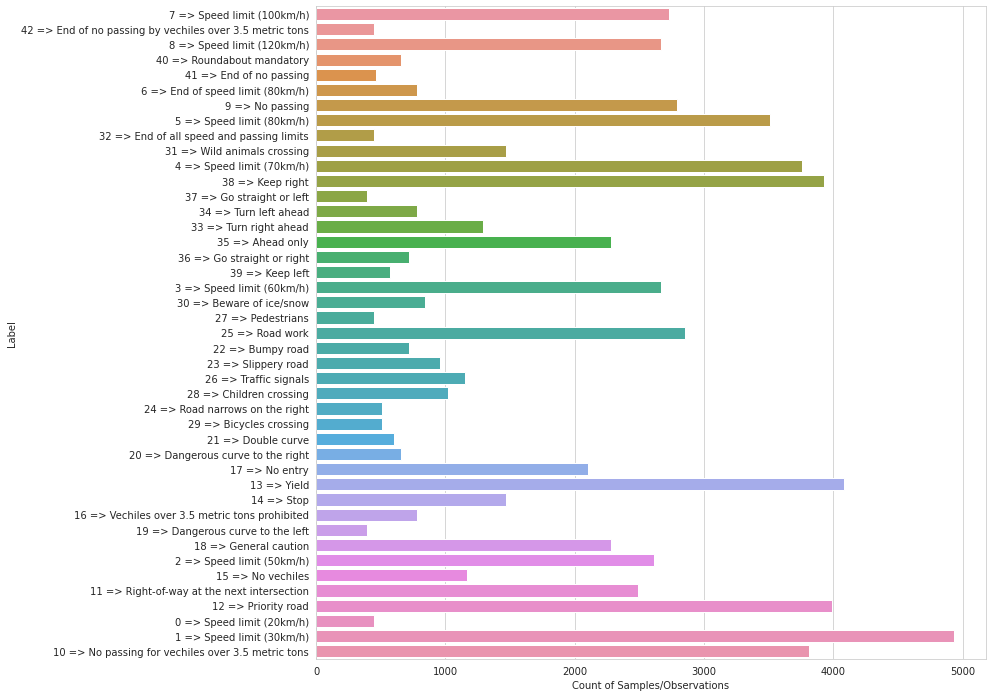

In [ ]:
d = dict()
class_labels = dict()
for dirs in os.listdir(path + '/myData'):
    count = len(os.listdir(path+'/myData/'+dirs))
    d[dirs+' => '+lab[lab.ClassId == int(dirs)].values[0][1]] = count
    class_labels[int(dirs)] = lab[lab.ClassId == int(dirs)].values[0][1]

plt.figure(figsize = (12, 12))
sns.barplot(y = list(d.keys()), x = list(d.values()))
plt.ylabel('Label')
plt.xlabel('Count of Samples/Observations');

In [ ]:
img_rows, img_cols = 32, 32
# The images are RGB.
img_channels = 3
nb_classes = len(class_labels.keys())
print("nb_classes:{}".format(nb_classes))

nb_classes:43


In [ ]:
datagen = ImageDataGenerator()
data = datagen.flow_from_directory('/content/drive/MyDrive/archive/myData',
                                    target_size=(32, 32),
                                    batch_size=1600,
                                    class_mode='categorical',
                                    shuffle=True )

Found 73179 images belonging to 43 classes.


In [ ]:
X , y = data.next()

In [ ]:
print(f"Data Shape   :{X.shape}\nLabels shape :{y.shape}")

Data Shape   :(1600, 32, 32, 3)
Labels shape :(1600, 43)


In [ ]:
def resnet_model():
    resnet = ResNet50V2(include_top=False, weights=None, input_shape= (img_rows,img_cols,img_channels))

    x = resnet.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3) (x)
    x = Dense(128) (x)
    x = LeakyReLU(alpha=0.2) (x)
    x = GaussianDropout(0.4) (x)
    predictions = Dense(nb_classes,activation="softmax", dtype='float32')(x)

    model = Model(inputs = resnet.input, outputs = predictions)
    return model

model = resnet_model()

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_check = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

csv_logger = CSVLogger('train_log.csv', separator=',')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
n_epochs = 40
history =  model.fit(X_train, y_train,  batch_size = 32, epochs = n_epochs, verbose = 1, 
                     validation_data = (X_test, y_test), 
                     callbacks = [model_check, early, reduce_lr, csv_logger])

Epoch 1/40
34/34 [==============================] - 84s 2s/step - loss: 4.0363 - accuracy: 0.0560 - val_loss: 169.0265 - val_accuracy: 0.0777 - lr: 0.0010
Epoch 2/40
34/34 [==============================] - 77s 2s/step - loss: 3.7408 - accuracy: 0.0672 - val_loss: 49.5441 - val_accuracy: 0.0758 - lr: 0.0010
Epoch 3/40
34/34 [==============================] - 77s 2s/step - loss: 3.7947 - accuracy: 0.0840 - val_loss: 5.5404 - val_accuracy: 0.0871 - lr: 0.0010
Epoch 4/40
34/34 [==============================] - 77s 2s/step - loss: 3.6605 - accuracy: 0.1073 - val_loss: 4.1013 - val_accuracy: 0.0947 - lr: 0.0010
Epoch 5/40
34/34 [==============================] - 77s 2s/step - loss: 3.4320 - accuracy: 0.1604 - val_loss: 3.4185 - val_accuracy: 0.0985 - lr: 0.0010
Epoch 6/40
34/34 [==============================] - 77s 2s/step - loss: 3.4603 - accuracy: 0.1334 - val_loss: 3.3443 - val_accuracy: 0.0777 - lr: 0.0010
Epoch 7/40
34/34 [==============================] - 77s 2s/step - loss: 3.3383 

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print('Accuracy:%.5f'%(acc))
print('Loss    :%.5f'%(loss))

17/17 [==============================] - 3s 158ms/step - loss: 1.6204 - accuracy: 0.6212
Accuracy:0.62121
Loss    :1.62039


In [ ]:
model.save('TSC_model.h')


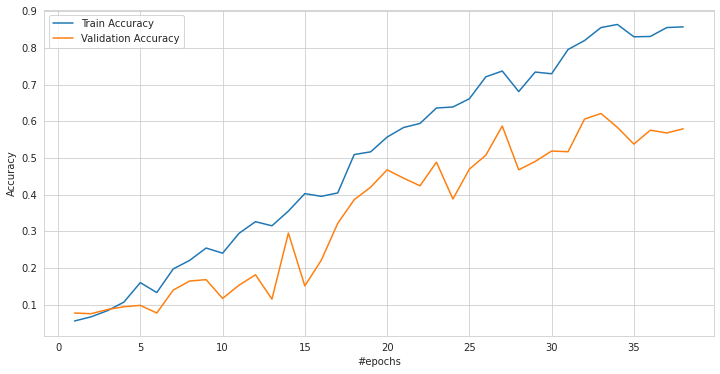

In [ ]:
q = len(list(history.history['loss']))
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Train Accuracy')
sns.lineplot(x = range(1, 1+q), y = history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('#epochs')
plt.ylabel('Accuracy')
plt.legend();

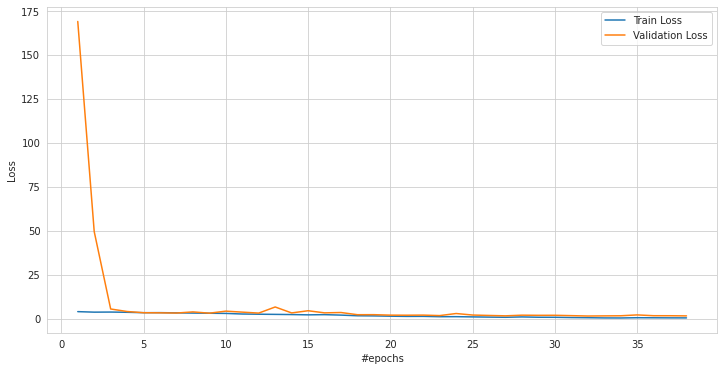

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Train Loss')
sns.lineplot(x = range(1, 1+q), y = history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('#epochs')
plt.ylabel('Loss')
plt.legend();

In [ ]:
pred = np.argmax(model.predict(X_test), axis = 1)

In [ ]:
labels = [class_labels[i] for i in range(42)]
print(classification_report(np.argmax(y_test, axis = 1), pred, target_names = labels))

                                              precision    recall  f1-score   support

                        Speed limit (20km/h)       0.00      0.00      0.00         2
                        Speed limit (30km/h)       0.55      0.78      0.65        27
                        Speed limit (50km/h)       0.96      0.86      0.91        29
                        Speed limit (60km/h)       0.77      0.87      0.82        23
                        Speed limit (70km/h)       0.81      0.81      0.81        31
                        Speed limit (80km/h)       0.77      1.00      0.87        33
                 End of speed limit (80km/h)       0.56      0.82      0.67        11
                       Speed limit (100km/h)       1.00      0.62      0.77         8
                       Speed limit (120km/h)       0.67      1.00      0.80         6
                                  No passing       1.00      0.70      0.82        10
No passing for vechiles over 3.5 metric tons       0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
classwise_acc = cmat.diagonal()/cmat.sum(axis=1) * 100 
cls_acc = pd.DataFrame({'Class_Label':[class_labels[i] for i in range(42)], 'Accuracy': classwise_acc.tolist()}, columns = ['Class_Label', 'Accuracy'])
cls_acc.style.format({"Accuracy": "{:,.2f}",}).hide_index().bar(subset=["Accuracy"], color='pink')

Class_Label,Accuracy
Speed limit (20km/h),0.00
Speed limit (30km/h),77.78
Speed limit (50km/h),86.21
Speed limit (60km/h),86.96
Speed limit (70km/h),80.65
Speed limit (80km/h),100.00
End of speed limit (80km/h),81.82
Speed limit (100km/h),62.50
Speed limit (120km/h),100.00
No passing,70.00


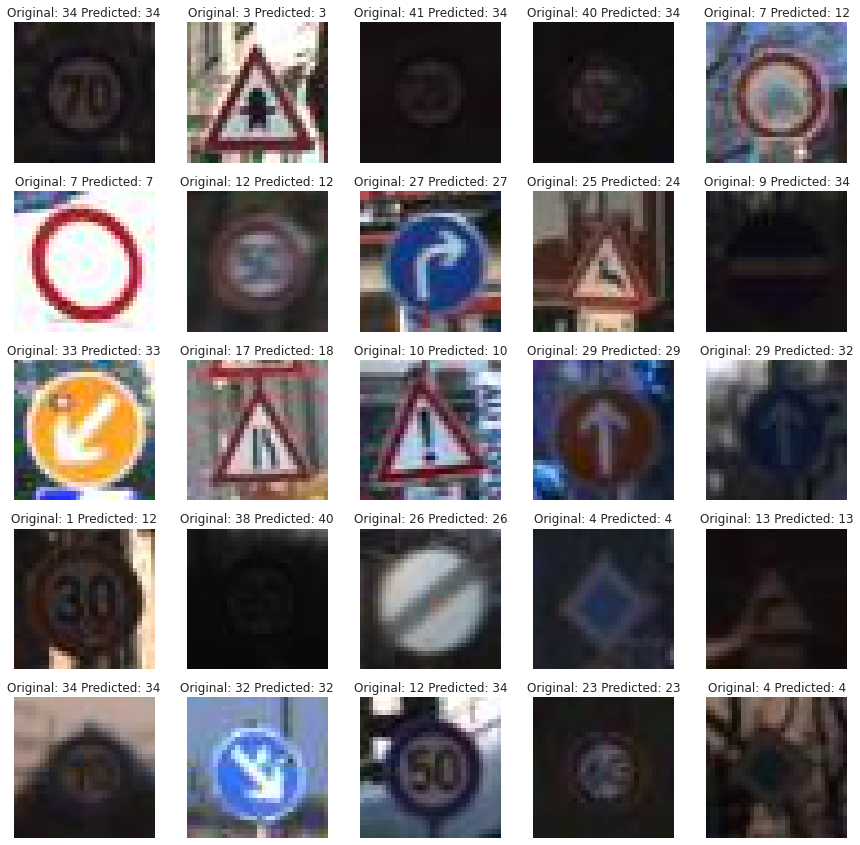

In [ ]:
fig, axes = plt.subplots(5,5, figsize=(15,15))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X_test.shape[0])
    ax.imshow(X_test[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Original: {} Predicted: {}'.format(np.argmax(y_test[r]), np.argmax(model.predict(X_test[r].reshape(1, 32, 32, 3)))))